# A SQLAlchemy Analysis on Climate in Honolulu, Hawaii

SQL | SQLite | SQLAlchemy | Pandas | Matplotlib |

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Data Exploration -- What's in the past?

## 1.  Reflect SQLite DataBase into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
inspector = inspect(engine)

In [8]:
# get Tables in the SQLite DataBase
tables = inspector.get_table_names()
# or using tables = Base.classes.keys()
print(tables)

['measurement', 'station']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# obtain column details for each table 
# Table 'measurement'
cols = inspector.get_columns('measurement')
print("Table:   Measurement\n---------------------")
for col in cols:
    print(col['name'], col['type'])
    
# Table 'station'
cols = inspector.get_columns('station')
print("\nTable:   Station\n---------------------")
for col in cols:
    print(col['name'], col['type'])
    
print()

Table:   Measurement
---------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Table:   Station
---------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## 2. Weather in the most recent year

In [12]:
# a function that take a string of date and turn it into datetime
def str_to_date(str_time):
    return dt.datetime.strptime(str_time,'%Y-%m-%d').date()

In [13]:
# Explore the days available in the Database
all_dates = session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).all()
all_dates = list(np.ravel(all_dates))
first_date = str_to_date(all_dates[-1])
last_date = str_to_date(all_dates[0])

delta = last_date - first_date - dt.timedelta(days = len(all_dates) -1)
if delta.days == 0:
    str = 'without missing days.'
else:
    str = f'with {delta.days} days missing'

print(f"There are {len(all_dates)} days in total, {str}")
print(f"First date: {first_date}.")
print(f"Last date: {last_date}.")

There are 2792 days in total, without missing days.
First date: 2010-01-01.
Last date: 2017-08-23.


In [14]:
# Calculate the date 1 year ago from the last data point in the database
one_year_from_last_day = dt.date(last_date.year - 1, last_date.month, last_date.day)

# Perform a query to retrieve the data and precipitation scores within the last year of record
prcp = session.query(Measurement.date, func.avg(Measurement.prcp)).\
               filter(Measurement.date >= one_year_from_last_day).\
               filter(Measurement.date <= last_date).\
               group_by(Measurement.date).\
               order_by(Measurement.date).all()

# print date range within analysis
print(f"Dates analyzed: {one_year_from_last_day} to {last_date}")

Dates analyzed: 2016-08-23 to 2017-08-23


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp, columns= ['date', 'average_precipitation'])
prcp_df.set_index('date', inplace = True)
prcp_df.head()

,average_precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


In [16]:
list_prcp = list(prcp_df['average_precipitation'])
mean_prcp = sum(list_prcp)/len(list_prcp) # annual average precipitation 

prcp_df_copy = prcp_df.copy().reset_index()
date_list = list(prcp_df_copy['date'])
mm = [x.split('-')[1] for x in date_list]
prcp_df_copy['mm'] = mm

bgc = [1] * len(mm)
for i in range(1, len(mm)):
    if mm[i] == mm[i-1]:
        bgc[i] = bgc[i-1]
    else:
        bgc[i] = -bgc[i-1]
        
prcp_df_copy['bgc'] = bgc # set alternate background color based on month

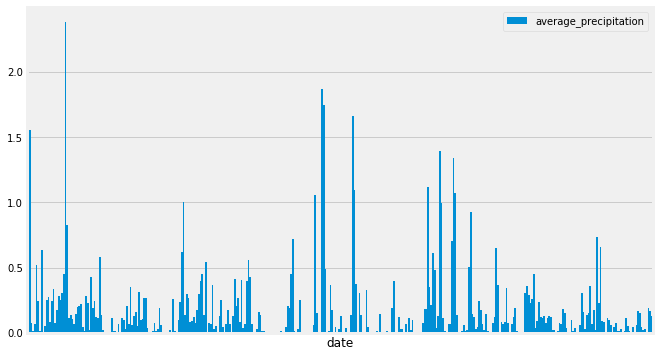

In [17]:
prcp_df.plot.bar(figsize = (10, 6),width = 1)
plt.xticks([])
plt.show()

### That looks ok.. but let's get a more intuitive plot

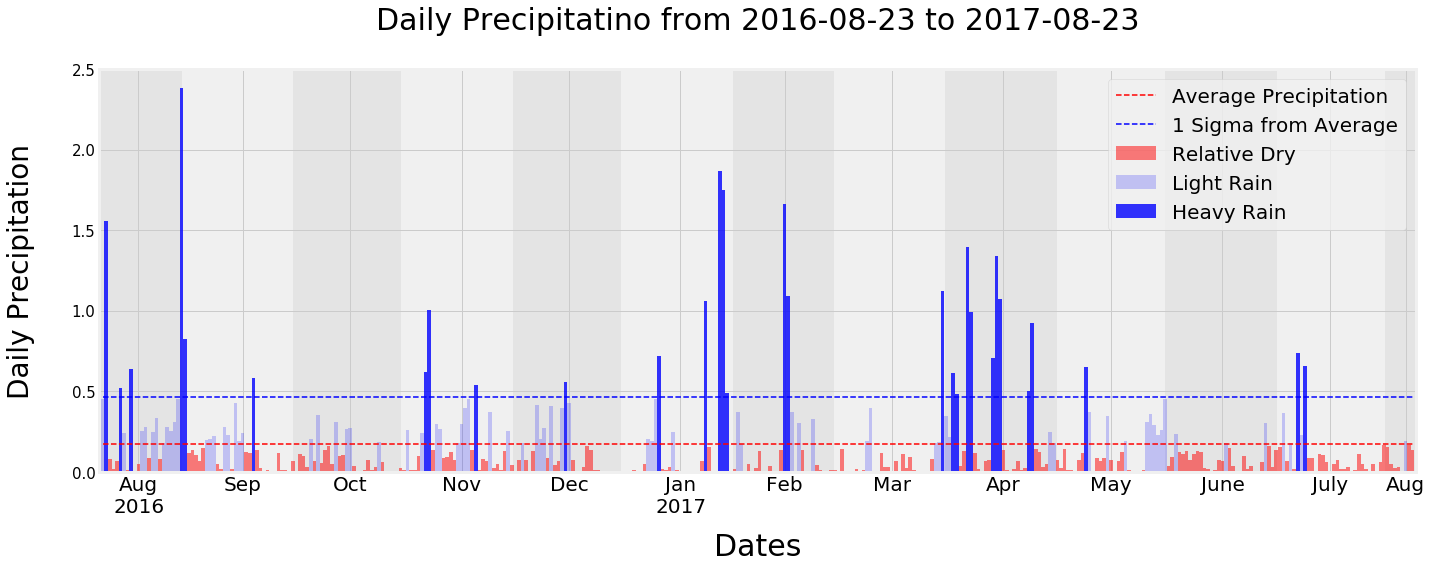

In [18]:
# Plot daily precipitation as bar chart

n = 1 # number of Sigma away from average

x = np.arange(len(list_prcp[:]))
y = np.array(list_prcp[:])

dry = y < mean_prcp
wet = (y >= mean_prcp) & (y < mean_prcp + n *  prcp_df['average_precipitation'].std())
very_wet = y >= mean_prcp + n *  prcp_df['average_precipitation'].std()

fig, ax = plt.subplots(figsize = (20, 8))
plt.hlines(mean_prcp,x[0], x[-1], 
           linewidth = 1.5, 
           linestyles = '--', 
           color = 'r',
           label = 'Average Precipitation')
plt.hlines(mean_prcp + n* prcp_df['average_precipitation'].std(),x[0], x[-1], 
           linewidth = 1.5, 
           linestyles = '--', 
           color = 'b',
           label = f'{n} Sigma from Average')

plt.bar(x[dry], y[dry], color = 'r', width = 1, alpha = 0.5, label = 'Relative Dry')
plt.bar(x[wet], y[wet], color = 'b', width = 1, alpha = 0.2, label = 'Light Rain')
plt.bar(x[very_wet], y[very_wet], color = 'blue', width = 1, alpha = 0.8, label = f'Heavy Rain')

ax.pcolorfast((-1, len(prcp_df[:])), ax.get_ylim(),
              prcp_df_copy['bgc'][::-1].values[np.newaxis],
              cmap='binary', alpha=0.05)
ticks = [i if mm[i] != mm[i-1] else 0 for i in range(len(mm))]
months = ['Aug', 'Sep', 'Oct', 'Nov','Dec','Jan', 'Feb','Mar','Apr','May','June','July','Aug']
ticks = [10] + [tick + 30  for tick in ticks if tick != 0]
adj = [0, 0, 0, 0, 0, 0, -2, 0, 0, 0,0, 0, -10]
ax.set_xticks([ticks[i] +  adj[i] for i in range(len(ticks))])
ax.set_xticklabels(months, fontsize = 20)
ax.set_yticklabels(np.arange(-0, 2.52, 0.50),fontsize = 15)
ax.text(3, -0.25, f"{one_year_from_last_day.year}", fontsize = 20)
ax.text(154, -0.25, f'{last_date.year}', fontsize = 20)

plt.xlim(-1, len(prcp_df[:]))
plt.ylim(0, 2.5)
plt.legend(fontsize = 20)
plt.xlabel('\nDates', fontsize = 30)
plt.ylabel('Daily Precipitation\n', fontsize= 28)
plt.title(f'Daily Precipitatino from {one_year_from_last_day} to {last_date}\n', fontsize = 30)

plt.tight_layout()
plt.savefig("Result/daily_precipitation.png")
plt.show()

## 3. Summary weather statistics across all data

In [19]:
all_prcp = session.query(Measurement.date, func.avg(Measurement.prcp)).\
               group_by(Measurement.date).\
               order_by(Measurement.date).all()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
all_prcp_df = pd.DataFrame(all_prcp, columns=["dates",'precipitation'])
all_prcp_df.set_index('dates', inplace = True)
all_prcp_df.describe()

,precipitation
count,2792.000000
mean,0.161962
std,0.345704
min,0.000000
25%,0.010000
50%,0.058333
75%,0.173571
max,5.970000


## 3. Weather Stations 

In [21]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).all()
print(f"Number of Stations: {len(stations)}")

Number of Stations: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_measurements = session.query(Station.station, func.count(Measurement.id)).\
                               filter(Station.station == Measurement.station).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.id).desc()).all()

most_active_station = station_measurements[0][0]
most_active_station_measurements = station_measurements[0][1]
print(f'''The most active station: \
 {most_active_station}, with {most_active_station_measurements} measurement records.\n''')

station_measurements

The most active station:  USC00519281, with 2772 measurement records.



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate:
# 1. the lowest temperature recorded, 
# 2. highest temperature recorded, and 
# 3. average temperature most active station

temp_at_station = session.query(func.min(Measurement.tobs), 
                                func.max(Measurement.tobs), 
                                func.avg(Measurement.tobs)).\
                          filter(Measurement.station == most_active_station).all()

print("\nRecords at the most avtive station:")
print("------------------------------------\n")
print(f"Lowest temp  : {temp_at_station[0][0]} F")
print(f"Hightest temp: {temp_at_station[0][1]} F")
print("Average temp : {:.1f} F".format(temp_at_station[0][2]))


Records at the most avtive station:
------------------------------------

Lowest temp  : 54.0 F
Hightest temp: 85.0 F
Average temp : 71.7 F


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_over_1_year = session.query(Measurement.tobs, Measurement.date).\
                           filter(Measurement.station == most_active_station).\
                           filter(Measurement.date > one_year_from_last_day).\
                           filter(Measurement.date <= last_date).\
                           order_by(Measurement.date).all()

In [25]:
temp_over_1_year_df = pd.DataFrame(temp_over_1_year, columns=["temp",'date'])

# binning 
bin_width = 2
min_temp = temp_over_1_year_df.temp.min()
max_temp = temp_over_1_year_df.temp.max()
bins = np.arange(min_temp // bin_width * bin_width , (max_temp//bin_width + 1)* bin_width, bin_width)
label_name = ["{}-{}".format(bins[i-1], bins[i]) for i in range(1, len(bins))]
temp_over_1_year_df['temp_range'] = pd.cut(temp_over_1_year_df['temp'],bins, labels = label_name)

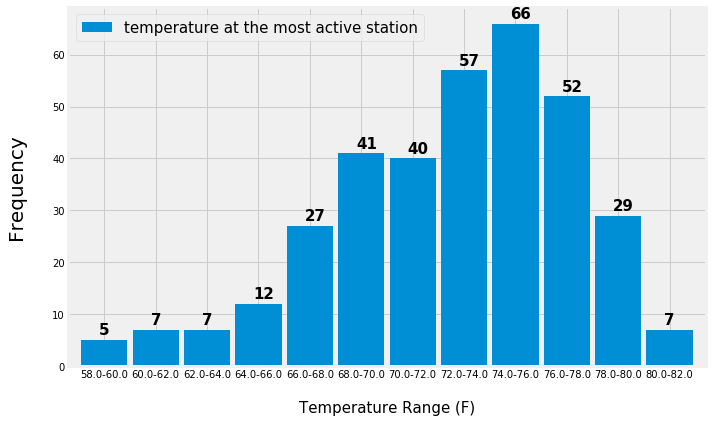

In [26]:
# group by frequency and plot as histogram
temp_freq_df = temp_over_1_year_df.groupby('temp_range').count()['temp']
ax = temp_freq_df.plot.bar(figsize = (10, 6), width = 0.9, label = 'temperature at the most active station')
ax.set_xticklabels(label_name, rotation = 0)

x = np.arange(len(label_name))
for i in range(len(label_name)):
    ax.text(i-0.1, temp_freq_df[i]+ 1, temp_freq_df[i], fontsize = 15, weight = "bold")
plt.xlabel("\nTemperature Range (F)",fontsize = 15)
plt.ylabel("Frequency\n",fontsize = 20)
plt.legend(fontsize = 15)
plt.tight_layout()
plt.savefig("Result/temperature_frequency.png")
plt.show()

# LET'S GO SURF! -- What will the weather be at my vacation? 

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


### Let's say our vacation is during Spring break -- (March 7th - 14th: 7days)

In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017, 3, 7)
duration = 7
end_date = start_date + dt.timedelta(days = duration)

print(calc_temps(start_date, end_date))

[(62.0, 70.68, 82.0)]


## 1. Average Temperature

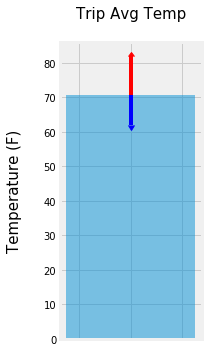

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

[min_temp, avg_temp, max_temp] = calc_temps(start_date, end_date)[0]
ax = plt.figure(figsize=(3, 5))
plt.bar(0, avg_temp, alpha = 0.5, width = 0.5)
plt.errorbar(0, avg_temp, yerr = avg_temp - min_temp, uplims=True, color = 'b')
plt.errorbar(0, avg_temp, yerr = max_temp - avg_temp, lolims=True, color = 'r')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.title("Trip Avg Temp\n", fontsize = 15)
plt.ylabel("Temperature (F)\n", fontsize = 15)
plt.tight_layout()
plt.savefig("Result/trip_temp.png")
plt.show()

## 2. Total precipitation at each station during my surf trip

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(func.sum(Measurement.prcp), 
                         Measurement.station, 
                         Station.name, 
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

In [31]:
rainfall_df = pd.DataFrame(rainfall, columns=['total_precipitation', 'station_id','name','lat','lng','elevation'])
rainfall_df

,total_precipitation,station_id,name,lat,lng,elevation
0,0.96,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,0.69,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.63,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,0.06,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,0.01,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
5,0.00,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.00,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


## 3. Daily Temperature Prediction

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
print(f"start day: {start_date}")
print(f"end day  : {end_date}")
print(f"trip duration: {duration}")

dates = [start_date + dt.timedelta(days = i) for i in range(duration)]
# Loop through the list of %m-%d strings and calculate the normals for each date
normal = []
for i in range(duration):
    day_normal = daily_normals(func.strftime("%m-%d", start_date + dt.timedelta(days = i)))
    normal.append(day_normal[0])
normal

start day: 2017-03-07
end day  : 2017-03-14
trip duration: 7


[(60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normal ,columns=['tmin','tavg','tmax'])
normal_df['date'] = dates
normal_df.set_index('date', inplace = True)
normal_df

,tmin,tavg,tmax
date,,,
2017-03-07,60.0,69.172414,78.0
2017-03-08,59.0,68.724138,78.0
2017-03-09,57.0,68.561404,75.0
2017-03-10,57.0,69.122807,75.0
2017-03-11,60.0,69.892857,82.0
2017-03-12,62.0,69.888889,80.0
2017-03-13,56.0,69.296296,77.0


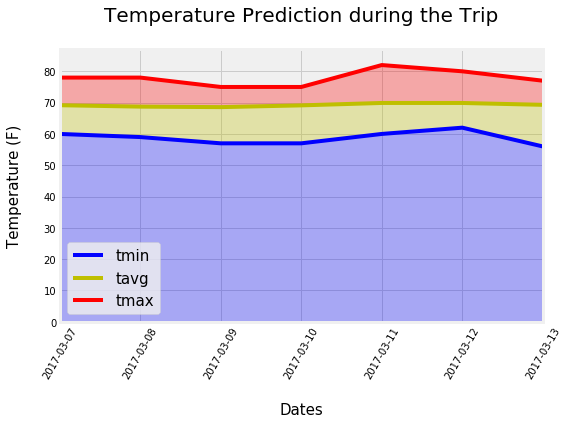

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
x = np.arange(duration)

plt.figure(figsize=(8, 6))
plt.plot(x, normal_df['tmin'], color= 'b', label = "tmin")
plt.plot(x, normal_df['tavg'], color= 'y', label = "tavg")
plt.plot(x, normal_df['tmax'], color= 'r', label = "tmax")
plt.fill_between(x, normal_df['tmin'], color = 'b', alpha = 0.3)
plt.fill_between(x, normal_df['tavg'],normal_df['tmin'], color = 'y', alpha = 0.3)
plt.fill_between(x, normal_df['tmax'],normal_df['tavg'], color = 'r', alpha = 0.3)

plt.xticks(x, dates, rotation = 60)
plt.xlabel("\nDates", fontsize = 15)
plt.ylabel('Temperature (F)\n', fontsize = 15)
plt.title("Temperature Prediction during the Trip\n", fontsize = 20)
plt.legend(fontsize = 15)
plt.xlim(x.min(), x.max())
plt.ylim(0,normal_df['tmax'].max() + 5)
plt.tight_layout()
plt.savefig("Result/daily_temperature_during_trip.png")
plt.show()